In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from keras import backend as K
import matplotlib.pyplot as plt
url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'
df = pd.read_csv(url, sep=',',header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
    'RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
df = pd.get_dummies(df,columns=["CHAS"]) #to categorical


C:\Users\Javier\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Javier\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<a id="segundo"></a>
## 2. Deep Networks
Las *deep network*, o lo que hoy en día se conoce como *deep learning*, hace referencia a modelos de redes neuronales estructurados con muchas capas, es decir, el cómputo de la función final es la composición una gran cantidad de funciones ( $f^{(n)} = f^{(n-1)} \circ f^{(n-2)} \circ \cdots \circ f^{(2)} \circ f^{(1)} $ con $n \gg 0$ ).  
Este tipo de redes neuronales tienen una gran cantidad de parámetros, creciendo exponencialmente por capa con las redes *feed forward*, siendo bastante dificiles de entrenar comparadas con una red poco profunda, esto es debido a que requieren una gran cantidad de datos para ajustar correctamente todos esos parámetros. Pero entonces ¿Cuál es el beneficio que tienen este tipo de redes? ¿Qué ganancias trae el añadir capas a una arquitectura de una red neuronal?  

<img src="http://neuralnetworksanddeeplearning.com/images/tikz36.png" title="Title text" width="80%" height="20%" />



En esta sección se estudiará la complejidad de entrenar redes neuronales profundas, mediante la visualización de los gradientes de los pesos en cada capa, el cómo varía mientras se hace el *backpropagation* hacia las primeras capas de la red. 

> a) Se trabajará con las etiquetas escaladas uniformemente, es decir, $\mu=0$ y $\sigma=1$, ajuste sobre el conjunto de entrenamiento y transforme éstas además de las de pruebas.

```python
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train_scaled = X_train_scaled.pop('MEDV').values.reshape(-1,1)
```

In [2]:
df_train,df_test= train_test_split(df,test_size=0.25, random_state=0)

In [3]:
y_train = df_train.pop('MEDV').reshape(-1,1)
y_test = df_test.pop('MEDV').reshape(-1,1)
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)

C:\Users\Javier\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
C:\Users\Javier\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [4]:
np.asmatrix(X_train_scaled).shape
y_train.shape

(379, 1)

> b) Para el mismo problema definido anteriormente ([sección 1](#primero)) se entrenará diferentes redes. En esta primera instancia se trabajará con la misma red de la pregunta b), inicializada con pesos uniforme. Visualice el gradiente de la función de pérdida (*loss*) para el conjunto de entrenamiento respecto a los pesos en las distintas capas, para esto se le pedirá el cálculo del gradiente para una capa mediante la función de *gradients* (__[link](https://www.tensorflow.org/api_docs/python/tf/keras/backend/gradients)__) en el *backend* de Keras. Deberá generar un **histograma** para todos los pesos de cada capa antes y despues del entrenamiento con 300 *epochs*. Comente.


In [5]:
def getGradients(modelo, xTrain, yTrain, loss):
    listOfVariableTensors = modelo.trainable_weights
    gradients = K.gradients(loss, listOfVariableTensors)
    sess = K.get_session()
    evaluated_gradients = sess.run(gradients, feed_dict={model.input:xTrain.as_matrix()})
    return [gradient/len(yTrain) for gradient in evaluated_gradients]

In [6]:
def getDataFromGrad(layers, gradsBefore, gradsAfter):
    
    nLayers = len(layers)
    nIter = 0
    nLayer = 0
    result = []
    
    for i in range(2*nLayers):
        auxList = []
        result.append(auxList)
        
    for gradients in [gradsBefore, gradsAfter]:
        nLayer = 0
        for layer in gradients:
            if (nLayer//2)+1 in layers:
                if nIter%2 == 0:
                    for vector in layer:
                        for element in vector:
                            result[(nIter//2)].append(element)
                else:
                    for element in layer:
                        result[(nIter//2)].append(element)
                nIter += 1
            nLayer+=1
    
    return result

In [7]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
loss = keras.losses.mean_squared_error(model.output, y_train)
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               3000      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [73]:
grad_bef_B = getGradients(model, X_train_scaled, y_train, loss)

In [75]:
hist_B = model.fit(np.asmatrix(X_train_scaled), 
                 np.asmatrix(y_train), 
                 epochs=300,
                 verbose=0, 
                 validation_data=(np.asmatrix(X_test_scaled), 
                                  np.asmatrix(y_test)
                                 )
                )

In [11]:
grad_aft_B = getGradients(model, X_train_scaled, y_train, loss)

In [12]:
itemB_data = getDataFromGrad([1,2], grad_bef_B, grad_aft_B)

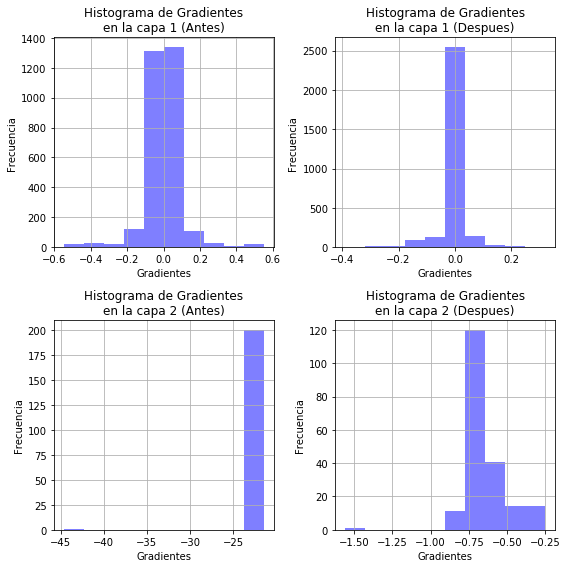

In [55]:
f, ax = plt.subplots(2, 2,figsize=(8,8))
ax = ax.T.flatten()
index = 0
realIndex = 0
for index in range(len(itemB_data)):

    if index%2 == 0:
        realIndex = int(index/2)
    else:
        realIndex = int(len(itemB_data)/2 + index//2)
    f.axes[index].hist(itemB_data[realIndex], facecolor='blue', alpha=0.5)
    f.axes[index].set_xlabel('Gradientes')
    f.axes[index].set_ylabel('Frecuencia')
    number = (index//2)+1
    if index%2 == 0:
        tiempo = "Antes"
    else:
        tiempo = "Despues"
    f.axes[index].set_title('Histograma de Gradientes\nen la capa '+str(number)+' ('+tiempo+')')
    f.axes[index].grid(True)
    index+=1
    
plt.tight_layout()
plt.show()

En general se observa una clara disminución de la magnitud de los gradientes, el cual es el fenómeno esperado en este escenario, considerando que se está utilzando una función de activación sigmoidal y una inicialización completamente "estándar". Sorprende que la disminución sea más brusca en la capa superior.

> c) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento pero ahora entrenando una red mucho mas profunda de 6 capas, 5 capas escondidas y 1 de salida. Utilice el inicializador de pesos *uniform* el cual inicializa mediante una distribución uniforme entre $-1/\sqrt{N}$ y $1/\sqrt{N}$ para cada capa, con $N$ el número de neuronas de la capa anterior. Por simplicidad visual visualice las 3-4 primeras capas de la red. Comente si observa el efecto del *gradiente desvaneciente* antes y/o después de entrenar.

In [56]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200,  kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
loss = keras.losses.mean_squared_error(model.output, y_train)

In [57]:
grad_bef_C = getGradients(model, X_train_scaled, y_train, loss)

In [58]:
model.fit(np.asmatrix(X_train_scaled), 
                 np.asmatrix(y_train), 
                 epochs=300,
                 verbose=0, 
                 validation_data=(np.asmatrix(X_test_scaled), 
                                  np.asmatrix(y_test)
                                 )
                )

In [59]:
grad_aft_C = getGradients(model, X_train_scaled, y_train, loss)

In [60]:
itemC_data = getDataFromGrad([1,2,3,4], grad_bef_C, grad_aft_C)

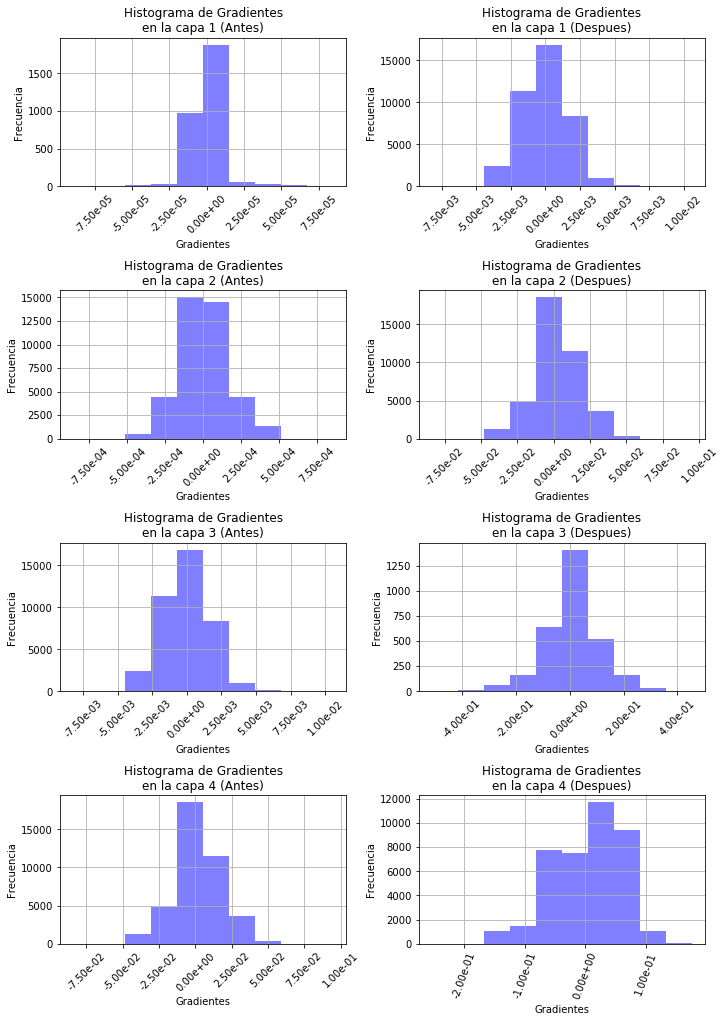

In [63]:
f, ax = plt.subplots(4,2,figsize=(10,14))
ax = ax.T.flatten()
for i in range(len(ax)):
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=45)

index = 0
realIndex = 0
for index in range(len(itemC_data)):
    
    if index%2 == 0:
        realIndex = int(index/2)
    else:
        realIndex = int(len(itemB_data)/2 + index//2)
        
    f.axes[index].hist(itemC_data[realIndex], facecolor='blue', alpha=0.5)
    f.axes[index].set_xlabel('Gradientes')
    f.axes[index].set_ylabel('Frecuencia')
    number = (index//2)+1
    if index%2 == 0:
        tiempo = "Antes"
    else:
        tiempo = "Despues"
    f.axes[index].set_title('Histograma de Gradientes\nen la capa '+str(number)+' ('+tiempo+')')
    f.axes[index].grid(True)
    f.axes[index].xaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
    index+=1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 
plt.xticks(rotation=70)
plt.show()

Se observa que los gradientes son pequeños en un principio, esto puede ser por el desbalance de las condiciones al inicializar el conjunto de pesos. 

> d) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento, pero ahora entrenando la red profunda con el inicializador de Glorot [[1]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/(N_{in}+N_{out})}$  y $\sqrt{6/(N_{in}+N_{out})}$ . Por simplicidad visualice las 3-4 primeras capas de la red. Comente si el efecto del *gradiente desvaneciente* se amortigua antes y/o después de entrenar.


In [20]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200,  kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='glorot_uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
loss = keras.losses.mean_squared_error(model.output, y_train)

In [21]:
grad_bef_D = getGradients(model, X_train_scaled, y_train, loss)

In [22]:
model.fit(np.asmatrix(X_train_scaled), 
                 np.asmatrix(y_train), 
                 epochs=300,
                 verbose=0, 
                 validation_data=(np.asmatrix(X_test_scaled), 
                                  np.asmatrix(y_test)
                                 )
                )

In [23]:
grad_aft_D = getGradients(model, X_train_scaled, y_train, loss)

In [24]:
itemD_data = getDataFromGrad([1,2,3,4], grad_bef_D, grad_aft_D)

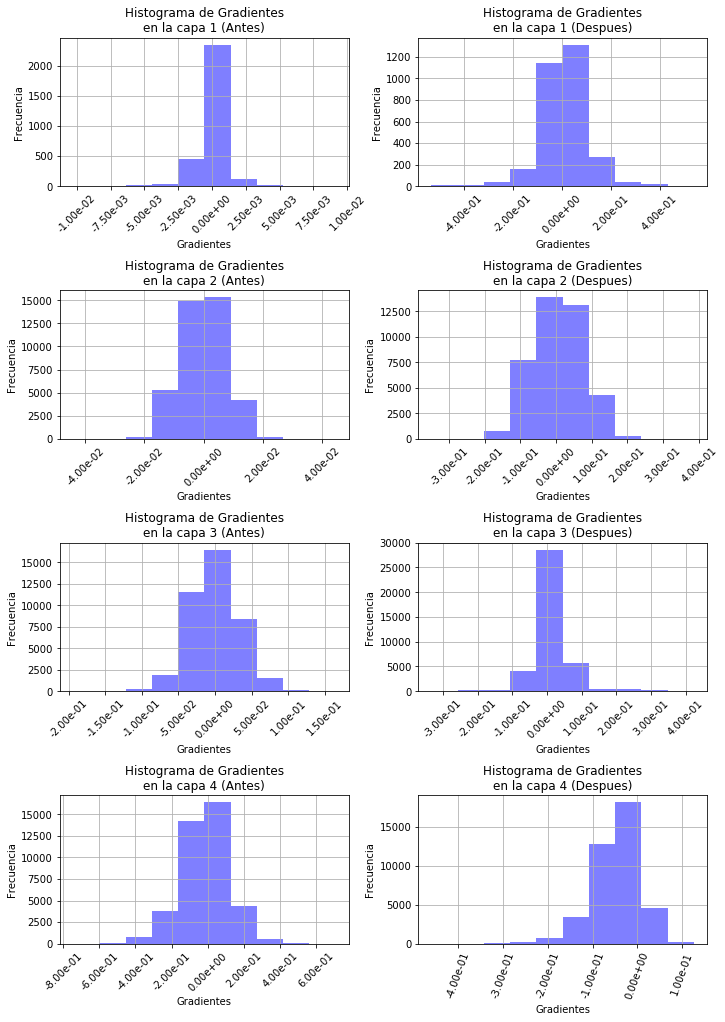

In [25]:
f, ax = plt.subplots(4,2,figsize=(10,14))
ax = ax.T.flatten()
for i in range(len(ax)):
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=45)

index = 0
realIndex = 0
for index in range(len(itemD_data)):
    
    if index%2 == 0:
        realIndex = int(index/2)
    else:
        realIndex = int(len(itemD_data)/2 + index//2)
        
    f.axes[index].hist(itemD_data[realIndex], facecolor='blue', alpha=0.5)
    f.axes[index].set_xlabel('Gradientes')
    f.axes[index].set_ylabel('Frecuencia')
    number = (index//2)+1
    if index%2 == 0:
        tiempo = "Antes"
    else:
        tiempo = "Despues"
    f.axes[index].set_title('Histograma de Gradientes\nen la capa '+str(number)+' ('+tiempo+')')
    f.axes[index].grid(True)
    f.axes[index].xaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
    index+=1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 
plt.xticks(rotation=70)
plt.show()

Dado que este método de inicialización toma en consideración la varianza tanto del input como del output, se observa como la magnitud de se mantiene estable en ambos frames temporales.

> e) Vuelva a repetir la experimentación ahora cambiando la función de activación por ReLU, es decir, deberá visualizar los gradientes de los pesos de cada capa antes y después del entrenamiento, con inicialización *uniform* y comparar con la inicialización de He [[2]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/N_{in}}$ y $\sqrt{6/N_{in}} $. Comente si ocurre el mismo fenómeno anterior (para función sigmoidal) sobre el efecto del *gradiente desvaneciente* para la función ReLU. Explique la importancia de la inicialización de los pesos dependiendo de la arquitectura.

In [64]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='uniform',activation='relu'))
model.add(Dense(200,  kernel_initializer='uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.001)
model.compile(optimizer=sgd,loss='mean_squared_error')
loss = keras.losses.mean_squared_error(model.output, y_train)

In [65]:
grad_bef_E1 = getGradients(model, X_train_scaled, y_train, loss)

In [66]:
model.fit(np.asmatrix(X_train_scaled), 
                 np.asmatrix(y_train), 
                 epochs=300,
                 verbose=0, 
                 validation_data=(np.asmatrix(X_test_scaled), 
                                  np.asmatrix(y_test)
                                 )
                )

In [67]:
grad_aft_E1 = getGradients(model, X_train_scaled, y_train, loss)

In [68]:
itemE1_data = getDataFromGrad([1,2,3,4], grad_bef_E1, grad_aft_E1)

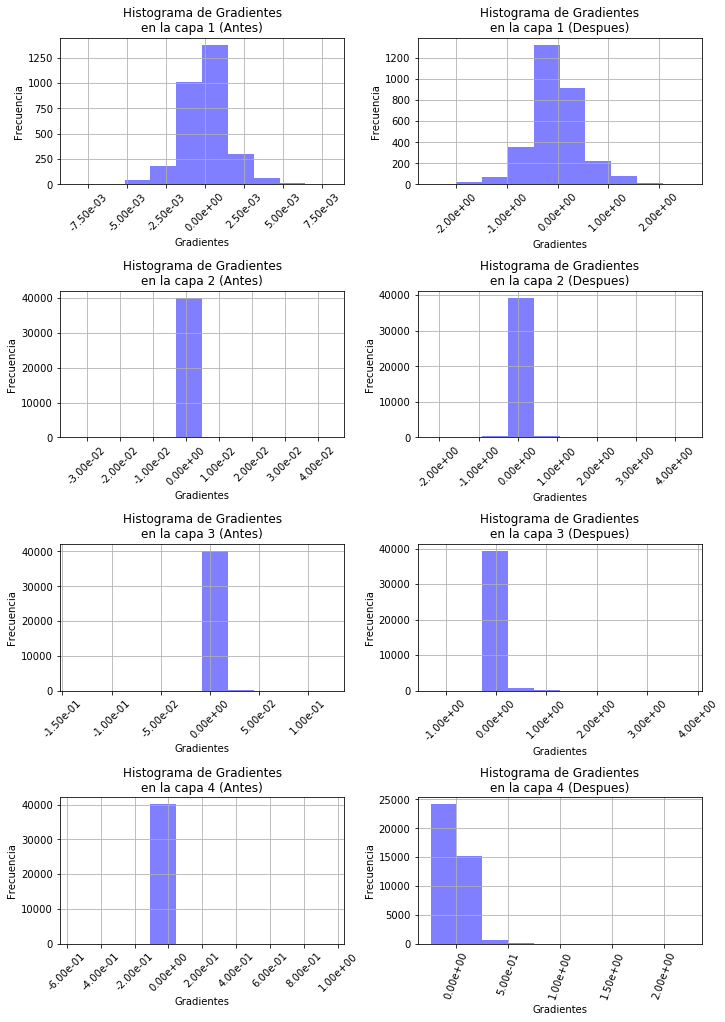

In [69]:
f, ax = plt.subplots(4,2,figsize=(10,14))
ax = ax.T.flatten()
for i in range(len(ax)):
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=45)

index = 0
realIndex = 0
for index in range(len(itemE1_data)):
    
    if index%2 == 0:
        realIndex = int(index/2)
    else:
        realIndex = int(len(itemD_data)/2 + index//2)
        
    f.axes[index].hist(itemE1_data[realIndex], facecolor='blue', alpha=0.5)
    f.axes[index].set_xlabel('Gradientes')
    f.axes[index].set_ylabel('Frecuencia')
    number = (index//2)+1
    if index%2 == 0:
        tiempo = "Antes"
    else:
        tiempo = "Despues"
    f.axes[index].set_title('Histograma de Gradientes\nen la capa '+str(number)+' ('+tiempo+')')
    f.axes[index].grid(True)
    f.axes[index].xaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
    index+=1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 
plt.xticks(rotation=70)
plt.show()

Para asegurar la convergencia de la red se disminuyó el *learning rate* del algoritmo de $0.1$ a $0.001$.

Dada la definición de ReLU se observan drásticas acumulaciones de los gradientes en el $0$.

In [32]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(200,  kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.001)
model.compile(optimizer=sgd,loss='mean_squared_error')
loss = keras.losses.mean_squared_error(model.output, y_train)

In [33]:
grad_bef_E2 = getGradients(model, X_train_scaled, y_train, loss)

In [34]:
model.fit(np.asmatrix(X_train_scaled), 
                 np.asmatrix(y_train), 
                 epochs=300,
                 verbose=0, 
                 validation_data=(np.asmatrix(X_test_scaled), 
                                  np.asmatrix(y_test)
                                 )
                )

In [35]:
grad_aft_E2 = getGradients(model, X_train_scaled, y_train, loss)

In [36]:
itemE2_data = getDataFromGrad([1,2,3,4], grad_bef_E2, grad_aft_E2)

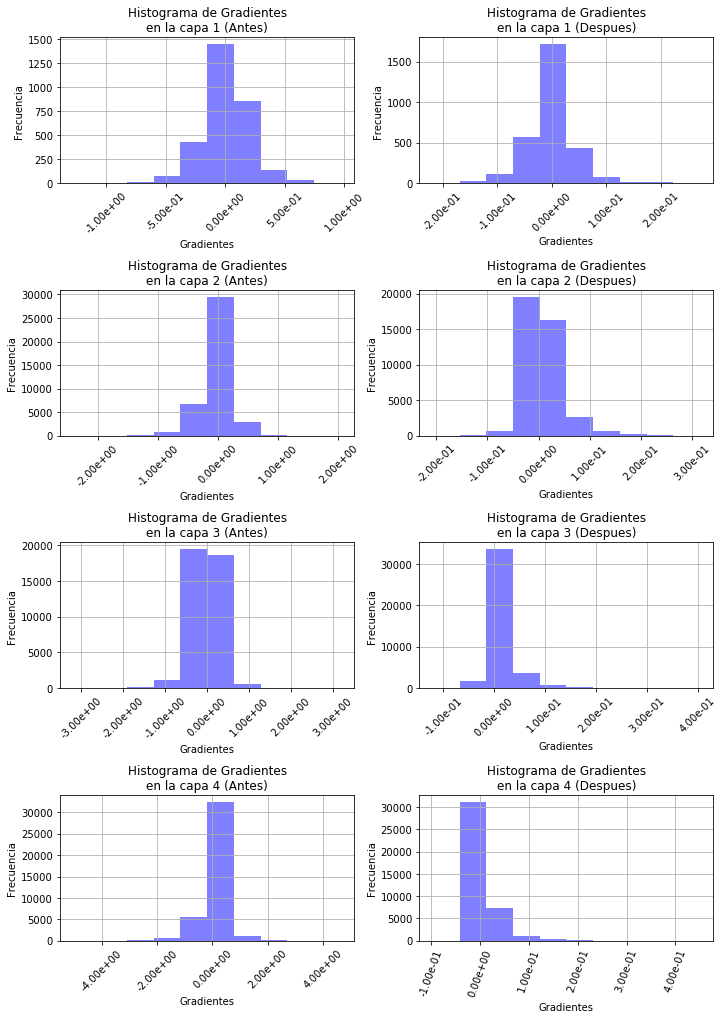

In [37]:
f, ax = plt.subplots(4,2,figsize=(10,14))
ax = ax.T.flatten()
for i in range(len(ax)):
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=45)

index = 0
realIndex = 0
for index in range(len(itemE2_data)):
    
    if index%2 == 0:
        realIndex = int(index/2)
    else:
        realIndex = int(len(itemD_data)/2 + index//2)
        
    f.axes[index].hist(itemE2_data[realIndex], facecolor='blue', alpha=0.5)
    f.axes[index].set_xlabel('Gradientes')
    f.axes[index].set_ylabel('Frecuencia')
    number = (index//2)+1
    if index%2 == 0:
        tiempo = "Antes"
    else:
        tiempo = "Despues"
    f.axes[index].set_title('Histograma de Gradientes\nen la capa '+str(number)+' ('+tiempo+')')
    f.axes[index].grid(True)
    f.axes[index].xaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
    index+=1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 
plt.xticks(rotation=70)
plt.show()

En este caso la red tiene un comportamiento más suave, permitiendo a una mayor cantidad de gradientes sobrevivir el entrenamiento. Esto tiene pros y contra, pero se considera como un mejor comportamiento al drástico sesgo de la inicialización anterior.

> e) ¿Qué es lo que sucede con la red más profunda? ¿El modelo logra convergencia en su entrenamiento? Modifique aspectos estructurales (funciones de activación, inicializadores, regularización, *momentum*, variación de tasa de aprendizaje, entre otros) de la red profunda de 6 capas definida anteriormente (no modifique la profundidad ni el número de neuronas) para lograr un error cuadrático medio (*mse*) similar o menor al de una red no profunda, como la definida en b) en esta sección, sobre el conjunto de pruebas.

In [96]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(200,  kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = optimizers.SGD(lr=0.001, decay=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)
loss = keras.losses.mean_squared_error(model.output, y_train)

In [101]:
hist_E = model.fit(np.asmatrix(X_train_scaled), 
                 np.asmatrix(y_train), 
                 epochs=300,
                 verbose=0, 
                 validation_data=(np.asmatrix(X_test_scaled), 
                                  np.asmatrix(y_test)
                                 )
                )

In [106]:
print("Minimal Loss red shallow (item b):", np.min(hist_B.history['val_loss']))
print("Minimal Loss red deep:", np.min(hist_E.history['val_loss']))

print("Mean Loss red shallow (item b):", np.mean(hist_B.history['val_loss']))
print("Mean Loss red deep:", np.mean(hist_E.history['val_loss']))

Minimal Loss red shallow (item b): 17.93581126806304
Minimal Loss red deep: 15.390538027906043
Mean Loss red shallow (item b): 19.811925921903192
Mean Loss red deep: 15.98394010986869


Se realizaron distintos ajustes de los parámetros de tasa de aprendizaje y la tasa de decaimiento del mismo, manteniendo un momentum de 0.9 con una heurística de Nesterov. Experimentalmente con ReLU ya se tiene el antecedente de que una tasa de aprendizaje del orden de $10^{-2}$ induce a la divergencia del algoritmo, en la mayoría de los casos desde $10^{-3}$ en "adelante" se tienen buenos resultados. Respecto a la tasa de decaimiento, esta fue variada iniciando desde $10^{-6}$ (de manera incremental), donde el algoritmo divergía hasta llegar a $10^{-2}$, valor que produjo los mejores resultados. Valores en el medio producían un aprendizaje lento, reflejado en el estancamiento de la reducción de *loss*.

> f) Pruebe con utilizar una red *shallow* (poco profunda), es decir, sitúe todas las neuronas en una única capa ¿Qué sucede con la convergencia del algoritmo? ¿Por qué sucede este fenómeno?

In [104]:
model = Sequential()
model.add(Dense(1000, input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='he_uniform',activation='linear'))
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_f1 = model.fit(np.asmatrix(X_train_scaled), 
                 np.asmatrix(y_train), 
                 epochs=300,
                 verbose=0, 
                 validation_data=(np.asmatrix(X_test_scaled), 
                                  np.asmatrix(y_test)
                                 )
                )

In [119]:
model = Sequential()
model.add(Dense(1000, input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='he_uniform',activation='linear'))
sgd = optimizers.SGD(lr=0.001, decay=0.001, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_f2 = model.fit(np.asmatrix(X_train_scaled), 
                 np.asmatrix(y_train), 
                 epochs=300,
                 verbose=0, 
                 validation_data=(np.asmatrix(X_test_scaled), 
                                  np.asmatrix(y_test)
                                 )
                )

In [118]:
print("Minimal Loss red shallow vanilla:", np.min(hist_f1.history['val_loss']))
print("Minimal Loss red shallow enhanced:", np.min(hist_f2.history['val_loss']))
print("Minimal Loss red deep:", np.min(hist_E.history['val_loss']))

print("\nMean Loss red shallow vanilla:", np.mean(hist_f1.history['val_loss']))
print("Mean Loss red shallow enhanced:", np.mean(hist_f2.history['val_loss']))
print("Mean Loss red deep:", np.mean(hist_E.history['val_loss']))

Minimal Loss red shallow vanilla: 26.897566847913847
Minimal Loss red shallow enhanced: 17.274630441440372
Minimal Loss red deep: 15.390538027906043

Mean Loss red shallow vanilla: 28.45787937880188
Mean Loss red shallow enhanced: 21.447334265345976
Mean Loss red deep: 15.98394010986869


Se observa que aún realizando ajustes a la red shallow, esta no fue capáz de sobrepasar la performance de la red profunda (aunque nada impide que bajo ciertas condiciones si la sobrepase). En general se tiene el consenso de que las redes neuronales profundas tienen una mayor capacidad para modelar escenarios de mayor complejidad al de las redes shallow. Esto por el crecimiento exponencial de las posibles activaciones neuronales por cada capa que se añade.